In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load your dataset
data = pd.read_csv('/content/labeled_windows_21.csv')

# Extract sequences and labels
X = data['Window']
y = data['Label']

# Combine features and labels into a single DataFrame
data = pd.DataFrame({'Window': X, 'Label': y})

# Separate data by class
class_0 = data[data['Label'] == 0]
class_1 = data[data['Label'] == 1]

# Find the number of samples in each class
num_class_0 = len(class_0)
num_class_1 = len(class_1)

# Determine the desired class sizes for a 2:1 ratio
desired_class_1_size = num_class_1
desired_class_0_size = 2 * desired_class_1_size

# Sample the data to achieve the desired ratio
if desired_class_0_size > num_class_0:
    print(f"Warning: Not enough class_0 samples. Reducing to maximum available ({num_class_0})")
    desired_class_0_size = num_class_0

class_0_balanced = class_0.sample(n=desired_class_0_size, random_state=42)
class_1_balanced = class_1.sample(n=desired_class_1_size, random_state=42)

# Combine the balanced data
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Shuffle the balanced dataset
balanced_data = shuffle(balanced_data, random_state=42)

# Extract balanced features and labels
X_balanced = balanced_data['Window']
y_balanced = balanced_data['Label']

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Combine features and labels for saving
train_set = pd.DataFrame({'Window': X_train, 'Label': y_train})
test_set = pd.DataFrame({'Window': X_test, 'Label': y_test})

# Save the datasets to CSV files
train_set.to_csv('/content/training_set_21.csv', index=False)
test_set.to_csv('/content/test_set_21.csv', index=False)

# Print shapes of resulting sets
print(f"Training data shape: {train_set.shape}, Training labels shape: {train_set['Label'].shape}")
print(f"Test data shape: {test_set.shape}, Test labels shape: {test_set['Label'].shape}")


Training data shape: (35400, 2), Training labels shape: (35400,)
Test data shape: (8850, 2), Test labels shape: (8850,)


In [1]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [2]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Function to extract BERT embeddings
def get_bert_embeddings(text):
    # Tokenize input text and get token IDs
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        input_ids = input_ids.cuda()

    with torch.no_grad():
        # Get model outputs
        outputs = model(input_ids)
        last_hidden_state = outputs.last_hidden_state

        # Aggregate embeddings by averaging token embeddings
        sequence_embeddings = last_hidden_state.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample text
print(get_bert_embeddings("Hello, how are you?"))


[-0.10193276 -0.34172472 -0.0024166  -0.31562588 -0.02676765 -0.3263679
  0.10514139  0.51999664  0.02761916 -0.32932872 -0.15544298 -0.36661485
 -0.19807681  0.29616237 -0.15293673  0.3756944  -0.05264042  0.01539636
 -0.27512738  0.6586474   0.10135886 -0.7263953  -0.01201719  0.4241749
  0.33361417 -0.26639026 -0.41605195 -0.00614732 -0.12374894 -0.6975255
  0.01728365  0.03412396 -0.6102075   0.0152922   0.30172887  0.08373855
 -0.02006742  0.09764107 -0.49192244  0.41998088 -0.7820611  -0.21670584
  0.0858752   0.25295067 -0.30259937 -0.93399864  0.13836232 -0.15772682
 -0.20713763 -0.30592263 -0.45860067  0.21019164 -0.3005243  -0.01702843
 -0.35179     0.717305   -0.3790838  -0.6268399  -0.5471046   0.06751759
 -0.05197052 -0.25975922  0.12054013 -0.43954998  0.14084835  0.69636977
  0.05487892  0.15067533 -0.6521598   0.15400012 -0.70396376 -0.5687703
 -0.00828763 -0.0650792  -0.23715687 -0.39737862 -0.5156072   0.13646522
 -0.5103701  -0.19066328 -0.31613067  0.39536825  0.167

In [5]:
# Load your data
train_data = pd.read_csv('/content/training_set_21.csv')
test_data = pd.read_csv('/content/test_set_21.csv')

# Select a subset of the data
train_data = train_data.sample(n=5000, random_state=42)
test_data = test_data.sample(n=300, random_state=42)

# Apply feature extraction
train_embeddings = train_data['Window'].apply(lambda x: get_bert_embeddings(x))
test_embeddings = test_data['Window'].apply(lambda x: get_bert_embeddings(x))

# Convert to numpy arrays
X_train = np.array(train_embeddings.tolist())
y_train = train_data['Label'].values
X_test = np.array(test_embeddings.tolist())
y_test = test_data['Label'].values

# Split the data further into training and validation sets


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
x_1, x_, y_1, y_ = train_test_split(X_train, y_train, test_size=1, random_state=1)

In [11]:
# x1_, x_, y1_, y_ = train_test_split(X, y, test_size=0.10, random_state=42)

In [12]:
# test_embeddings = test_data['Window'].apply(lambda x: get_bert_embeddings(x_))

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [6]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
ann_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
ann_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:38:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KNeighborsClassifier(n_neighbors=3)

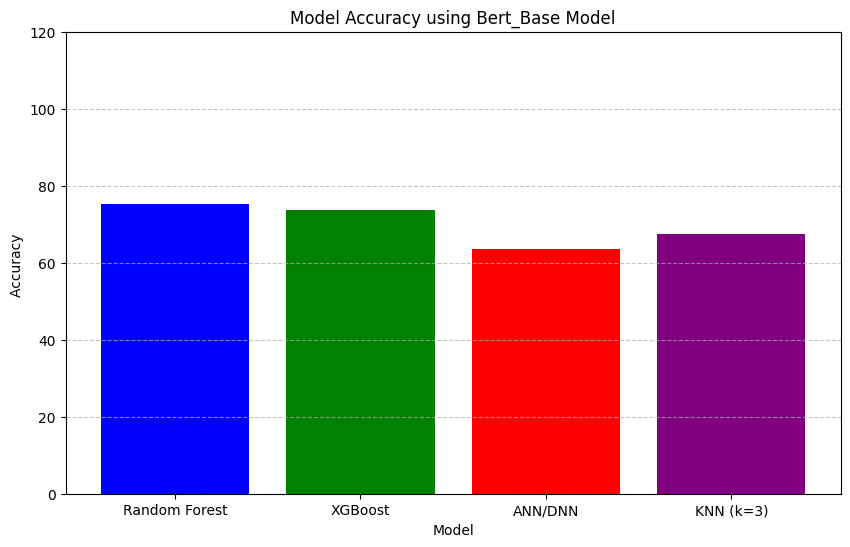

Random Forest Final Accuracy: 65.33%
XGBoost Final Accuracy: 64.67%
ANN/DNN Final Accuracy: 55.67%
KNN Final Accuracy: 60.33%


In [28]:
#  Predict and evaluate on validation set
rf_val_predictions = rf_model.predict(X_val)
xgb_val_predictions = xgb_model.predict(X_val)
ann_val_predictions = ann_model.predict(X_val)
knn_val_predictions = knn_model.predict(X_val)

rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
ann_val_accuracy = accuracy_score(y_val, ann_val_predictions)
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)

# Predict and evaluate on test set
rf_test_predictions = rf_model.predict(X_test)
xgb_test_predictions = xgb_model.predict(X_test)
ann_test_predictions = ann_model.predict(X_test)
knn_test_predictions = knn_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
ann_test_accuracy = accuracy_score(y_test, ann_test_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

# Convert accuracies to percentages
accuracies = {
    'Random Forest': rf_test_accuracy * 100,
    'XGBoost': xgb_test_accuracy * 100,
    'ANN/DNN': ann_test_accuracy * 100,
    'KNN (k=3)': knn_test_accuracy * 100
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy ')
plt.title('Model Accuracy using Bert_Base Model')
plt.ylim(0, 120)  # Set y-axis limit to accommodate accuracy percentages
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print final accuracies
print(f'Random Forest Final Accuracy: {rf_test_accuracy * 100:.2f}%')
print(f'XGBoost Final Accuracy: {xgb_test_accuracy * 100:.2f}%')
print(f'ANN/DNN Final Accuracy: {ann_test_accuracy * 100:.2f}%')
print(f'KNN Final Accuracy: {knn_test_accuracy * 100:.2f}%')


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load ProtBERT model and tokenizer
model_name = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get ProtBERT embeddings
def get_protbert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {key: value.cuda() for key, value in inputs.items()}
        model.cuda()
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
    sequence_embeddings = embeddings.mean(dim=1).cpu().numpy().flatten()
    return sequence_embeddings

# Load your data
train_data = pd.read_csv('/content/training_set_21.csv')
test_data = pd.read_csv('/content/test_set_21.csv')

# Select a subset of the data
train_data = train_data.sample(n=5000, random_state=42)
test_data = test_data.sample(n=300, random_state=42)

# Apply feature extraction
train_embeddings = train_data['Window'].apply(lambda x: get_protbert_embeddings(x))
test_embeddings = test_data['Window'].apply(lambda x: get_protbert_embeddings(x))

# Convert to numpy arrays
X_train = np.array(train_embeddings.tolist())
y_train = train_data['Label'].values
X_test = np.array(test_embeddings.tolist())
y_test = test_data['Label'].values

# Split the data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
ann_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
ann_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

# Predict and evaluate on validation set
rf_val_predictions = rf_model.predict(X_val)
xgb_val_predictions = xgb_model.predict(X_val)
ann_val_predictions = ann_model.predict(X_val)
knn_val_predictions = knn_model.predict(X_val)

rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
ann_val_accuracy = accuracy_score(y_val, ann_val_predictions)
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)

# Predict and evaluate on test set
rf_test_predictions = rf_model.predict(X_test)
xgb_test_predictions = xgb_model.predict(X_test)
ann_test_predictions = ann_model.predict(X_test)
knn_test_predictions = knn_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
ann_test_accuracy = accuracy_score(y_test, ann_test_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

# Convert accuracies to percentages
accuracies = {
    'Random Forest': rf_test_accuracy * 100,
    'XGBoost': xgb_test_accuracy * 100,
    'ANN/DNN': ann_test_accuracy * 100,
    'KNN (k=3)': knn_test_accuracy * 100
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy (%)')
plt.ylim(0, 120)  # Set y-axis limit to accommodate accuracy percentages
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print final accuracies
print(f'Random Forest Final Accuracy: {rf_test_accuracy * 100:.2f}%')
print(f'XGBoost Final Accuracy: {xgb_test_accuracy * 100:.2f}%')
print(f'ANN/DNN Final Accuracy: {ann_test_accuracy * 100:.2f}%')
print(f'KNN Final Accuracy: {knn_test_accuracy * 100:.2f}%')


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

KeyboardInterrupt: 